# import

In [3]:
import pandas as pd
import numpy as np
import os, sys, glob, re
from pathlib import Path
from scipy.interpolate import interp2d
from emgineer import EmgDecomposition, plot_spikes
import matplotlib.pyplot as plt

sys.path.append('../load_intan_rhd_format')

from load_filt_test import read_data, guolv

def filt_all_rhd(path):
    rhd = read_data(path)
    array_emg = rhd['amplifier_data']
    array_emg = array_emg[:, 2000:]
    array_emg_filt = guolv(array_emg).T
    return array_emg_filt

def get_newest_file(path_root):
    list_filename = [os.path.basename(p) for p in glob.glob(path_root + '/*', recursive=True) 
                    if re.search('(\w|\W)*[0-9]{6}_[0-9]{6}', os.path.basename(p))]
    filename = [i for _,i in sorted(zip([x[-13:] for x in list_filename],list_filename), reverse=True)][0]
    return filename

def plot_sensor_grid(M, n_lim=None, figsize=(16.0, 10.0), cmap='viridis', interporate_rate=1):
    if n_lim is None:
        n_lim = M.shape[0]
    plt.rcParams['figure.figsize'] = figsize
    fig = plt.figure()
    fig, axes = plt.subplots(nrows=-(-n_lim//5), ncols=5, sharex=False)
    for i in range(n_lim):
        _electrodes = M[i, :64].reshape((8, 8))
        if interporate_rate != 1:
            _electrodes = interporate_grid(_electrodes, rate=interporate_rate)
        axes[i//5, i%5].pcolor(_electrodes, cmap=cmap)
        axes[i//5, i%5].tick_params(
            labelbottom=False,
            labelleft=False,
            labelright=False,
            labeltop=False,
            bottom=False,
            left=False,
            right=False,
            top=False)
        axes[i//5, i%5].set_title('MU ' + str(i))

def interporate_grid(Z, rate=2):
    x = np.linspace(0, 7, 8)
    y = np.linspace(0, 7, 8)
    
    x2 = np.linspace(0, 7, int(8 * rate))
    y2 = np.linspace(0, 7, int(8 * rate))
    # X2, Y2 = np.meshgrid(x2, y2)

    f = interp2d(x, y, Z, kind='cubic')
    Z2 = f(x2, y2)
    return Z2


# Decomp


Reading Intan Technologies RHD2000 Data File, Version 3.0

n signal groups 11
Found 64 amplifier channels.
Found 3 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 23.424 seconds of data.  Amplifiers were sampled at 2.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.3 seconds
start decomp
end decomp


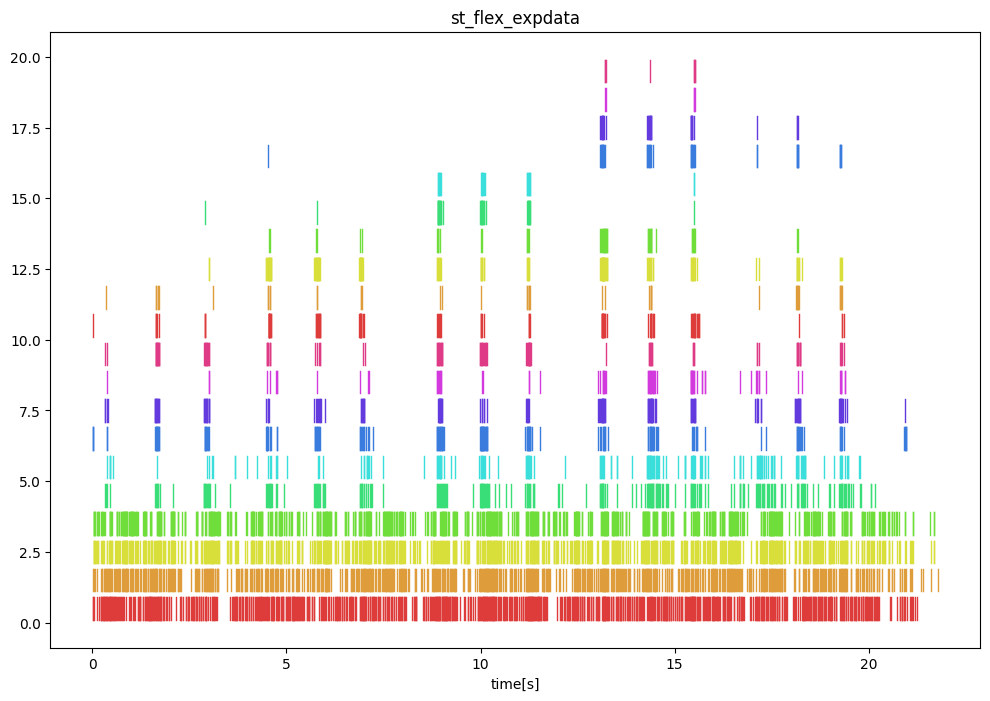

In [5]:
path_root = 'G:/共有ドライブ/MFG/project/Biomedical engineering/Project プロジェクト/Bionic hand/EMG実験/20221217'
filename = get_newest_file(path_root)
filename = 'five_221217_171758'
path = f'{path_root}/{filename}/{filename}.rhd'

emg_filt = filt_all_rhd(path)

# decomp
emg_flex = emg_filt[:, :64]

print('start decomp')
est_flex = EmgDecomposition(
    n_motor_unit=20,
    n_delayed=8,
    random_state=0,
    cashe=filename,
    flag_sil=False,
    flag_pca=False)
est_flex.fit(emg_flex)
st_flex, mu_flex = est_flex.transform(emg_flex)

print('end decomp')
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plot_spikes(st_flex[:, :20][:, ::-1], title='st_flex_expdata')

<Figure size 1600x1000 with 0 Axes>

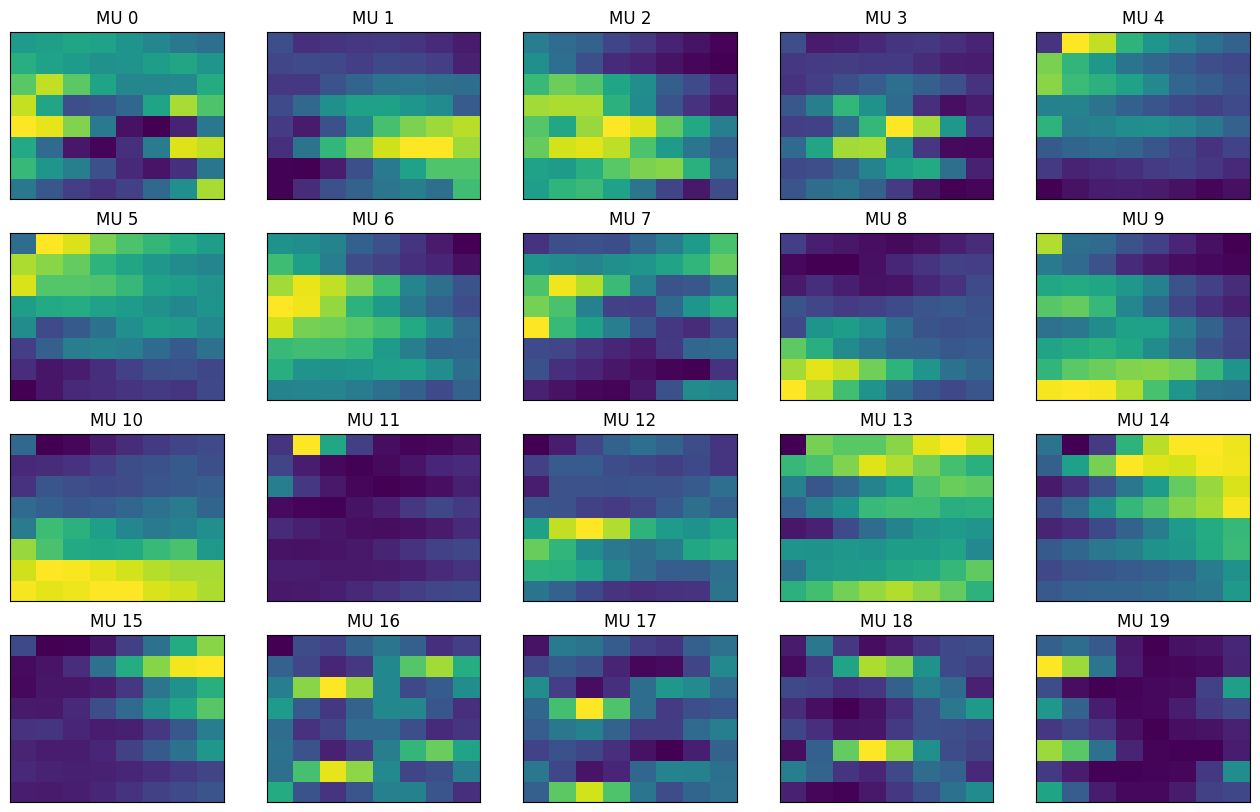

In [3]:
# ここで、C = np.dot(ummixing_matrix, whitening_matrix)
C = est_flex._FastICA.mixing_.T

# extendした信号を足し合わせる, spike trainsを算出するとき負の値は二乗されて正になるので、square(absでもできるが強調のためsquare)
mix_all = np.square(C).reshape((C.shape[0], -1, 64)).sum(axis=1)

plot_sensor_grid(mix_all, n_lim=20, interporate_rate=1)